In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import plotly.express as px
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.arima.model import ARIMA
import itertools
from numpy.linalg import LinAlgError

import warnings
warnings.filterwarnings("ignore")

# Read Dataset

https://opendata.cbs.nl/statline/#/CBS/nl/dataset/70895ned/table?fromstatweb

In [52]:
df = pd.read_csv('deaths_NL.csv')
df.head()

,Week,All ages: both sexes,All ages: men,All ages: women,0 to 65: both sexes,0 to 65: men,0 to 65: women,65 to 80: both sexes,65 to 80: men,65 to 80: women,80+: both sexes,80+: men,80+: women
0,1995 week 1,2719,1325,1394,476,283,193,901,546,355,1342,496,846
1,1995 week 2,2823,1393,1430,511,305,206,955,570,385,1357,518,839
2,1995 week 3,2609,1279,1330,473,282,191,888,540,348,1248,457,791
3,1995 week 4,2664,1366,1298,513,334,179,880,543,337,1271,489,782
4,1995 week 5,2577,1341,1236,484,316,168,874,539,335,1219,486,733


In [53]:
df = df[df["Week"].str.len()<20]
df['Week'] = df['Week'].str.replace('*', '')
df["Week"] = pd.to_datetime(df["Week"]+'0', format="%Y week %U%w")

In [54]:
df.head()

,Week,All ages: both sexes,All ages: men,All ages: women,0 to 65: both sexes,0 to 65: men,0 to 65: women,65 to 80: both sexes,65 to 80: men,65 to 80: women,80+: both sexes,80+: men,80+: women
0,1995-01-01,2719,1325,1394,476,283,193,901,546,355,1342,496,846
1,1995-01-08,2823,1393,1430,511,305,206,955,570,385,1357,518,839
2,1995-01-15,2609,1279,1330,473,282,191,888,540,348,1248,457,791
3,1995-01-22,2664,1366,1298,513,334,179,880,543,337,1271,489,782
4,1995-01-29,2577,1341,1236,484,316,168,874,539,335,1219,486,733


In [55]:
# Make Datetime column to index
df.set_index('Week', inplace=True)

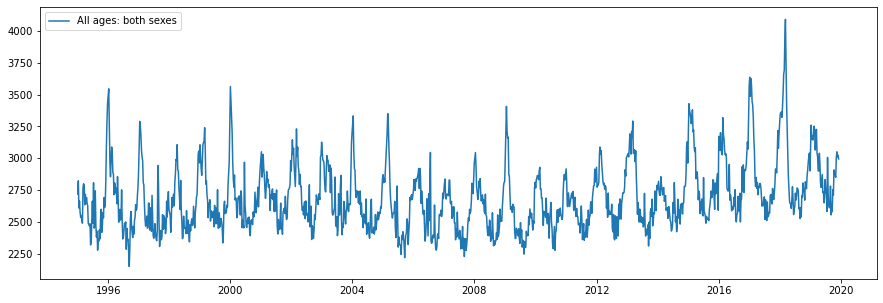

In [56]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['All ages: both sexes'], label='All ages: both sexes')
plt.legend()
plt.show()

In [57]:
df = df[(df.index.year >= 2014)] 
df = df.iloc[:, :1]

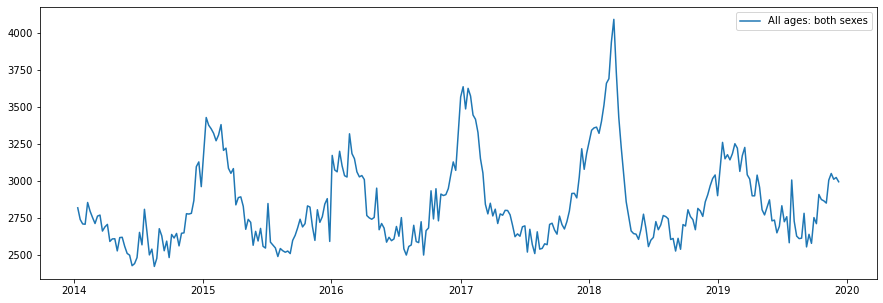

In [58]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['All ages: both sexes'], label='All ages: both sexes')
plt.legend()
plt.show()

## Resample Data

In [59]:
# Resample to weekhly precip sum and save as new dataframe
df = df.resample('W').sum().asfreq(freq = 'W')
df.index.freq = 'W'

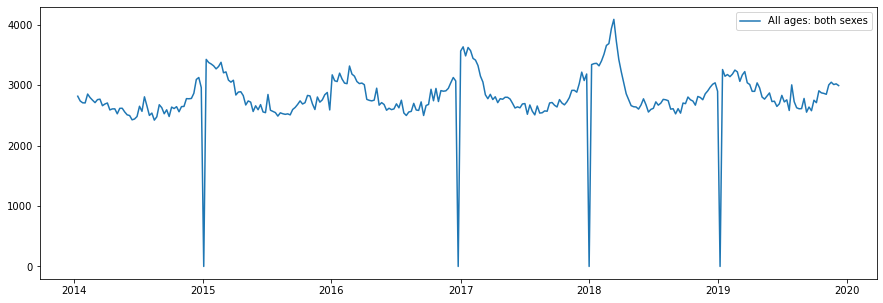

In [60]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['All ages: both sexes'], label='All ages: both sexes')
plt.legend()
plt.show()

## View Pattern

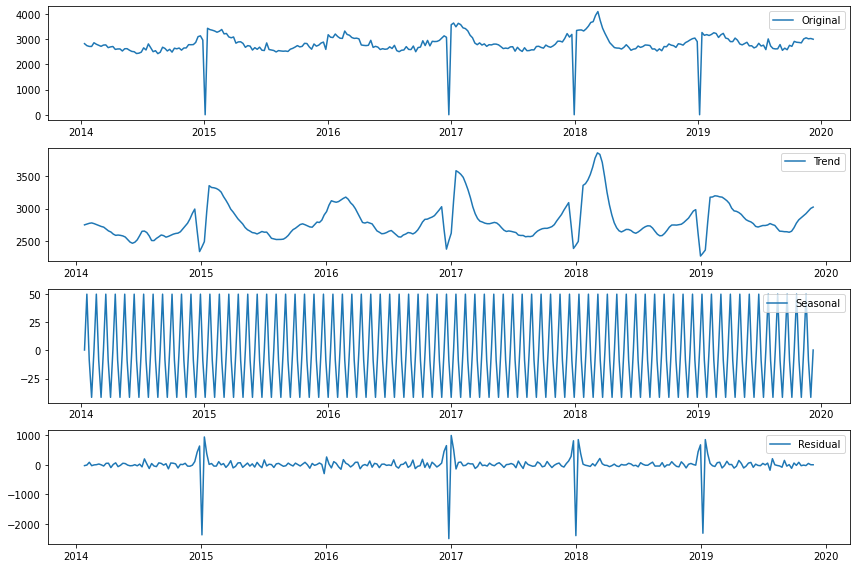

In [61]:
# Perform time series decomposition
result = seasonal_decompose(df['All ages: both sexes'], model='additive', period=4)  # 'additive' or 'multiplicative' depending on the nature of your data

# Plot the original, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['All ages: both sexes'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

Data time series yang dimiliki tidak menunjukkan adanya trend peningkatan yang signifikan. Data memiliki pola musiaman, dapat dilihat dari grafik atau komponen musiman yang terlihat teratur. varian residu juga terlihat stabil, hal itu menunjukan bahwa data tersebut bersifat stasioner.

### Trend

Peningkatan atau penurunan data dalam jangka panjang. Hal ini dapat dilihat sebagai kemiringan (tidak harus linier) pada seluruh data.

### Seasonal

Suatu rangkaian waktu dikatakan musiman jika dipengaruhi oleh faktor musiman (jam dalam sehari, minggu, bulan, tahun, dll.). Musiman dapat diamati dengan pola siklus yang bagus dengan frekuensi tetap.

### Residual

Setiap deret waktu dapat didekomposisi menjadi dua bagian:
- Forecasting, terdiri dari satu atau beberapa nilai perkiraan
- Residual, merupakan perbedaan antara observasi dan nilai prediksinya pada setiap langkah waktu

### Stationarity

Stasioneritas adalah sifat yang menunjukkan sifat statistik yang konstan (mean, varians, autokorelasi, dll.). Jika rata-rata suatu deret waktu meningkat seiring berjalannya waktu, maka deret tersebut tidak stasioner.

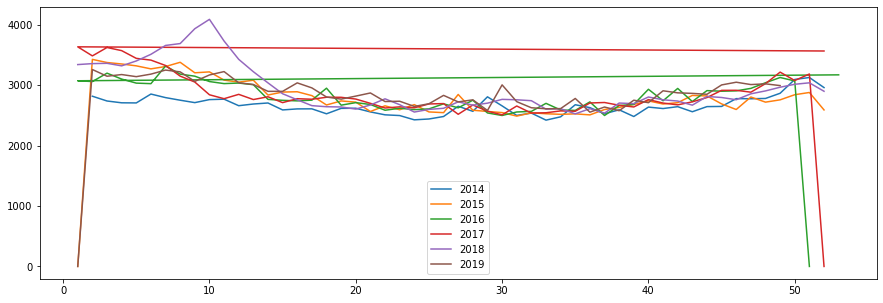

In [62]:
plt.figure(figsize=(15,5))
for i in df.index.year.unique():
    df_year = df[df.index.year == i].copy()
    plt.plot(df_year.index.week, df_year['All ages: both sexes'], label=i)
    plt.legend()
plt.show()


# Train and Test Split

In [63]:
def train_test_split(df: pd.DataFrame, train_set, test_set):
    train_set = df[df.index <= train_end]
    test_set = df[df.index > train_end]
    return train_set, test_set


train_end = datetime(2019,1,1)
test_end = datetime(2020,1,1)

# Naive Seasonal

## Data

In [72]:
naive_df = df.copy()

# split data train and test
train_df, test_df = train_test_split(naive_df, train_end, test_end)

In [75]:
train_df = train_df['All ages: both sexes'].to_numpy()
test_df = test_df['All ages: both sexes'].to_numpy()

## Build Model

In [66]:
def naive_seasonal_forecast(naive_df, seasonal_period, n_pred):
    predictions = []
    for i in range(seasonal_period, len(naive_df) + n_pred):
        predictions.append(naive_df[i - seasonal_period])
    return predictions

## Naive Seasonal Test

In [96]:
n_pred = 1
seasonal_period = 52
naive_seasonal_predictions = naive_seasonal_forecast(train_df, seasonal_period, n_pred)

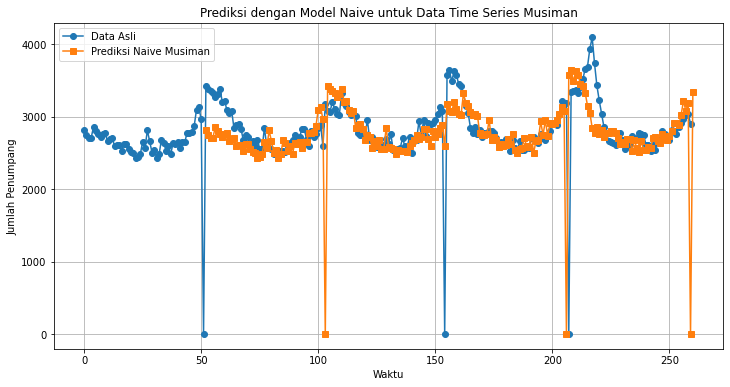

In [97]:
# Plot data asli dan prediksi Naive
plt.figure(figsize=(12, 6))
plt.plot(train_df, label='Data Asli', marker='o')
plt.plot(range(seasonal_period, len(train_df)+n_pred), naive_seasonal_predictions, label='Prediksi Naive Musiman', marker='s')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Penumpang')
plt.title('Prediksi dengan Model Naive untuk Data Time Series Musiman')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
# Function to calculate Mean Squared Error (MSE)
def calculate_mse(predictions, actual_data):
    mse = mean_squared_error(actual_data, predictions)
    return mse

# Function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(predictions, actual_data):
    mse = mean_squared_error(actual_data, predictions)
    rmse = np.sqrt(mse)
    return rmse


# Calculate MSE and RMSE
mse_naive_seasonal = calculate_mse(naive_seasonal_predictions[:len(test_df)], test_df)
rmse_naive_seasonal = calculate_rmse(naive_seasonal_predictions[:len(test_df)], test_df)

print(f"MSE Naive Musiman: {mse_naive_seasonal:.2f}")
print(f"RMSE Naive Musiman: {rmse_naive_seasonal:.2f}")



MSE Naive Musiman: 248050.04
RMSE Naive Musiman: 498.05


## Naive Seasonal Test - Short Term

In [99]:
n_pred = 26
seasonal_period = 52
naive_seasonal_predictions = naive_seasonal_forecast(train_df, seasonal_period, n_pred)

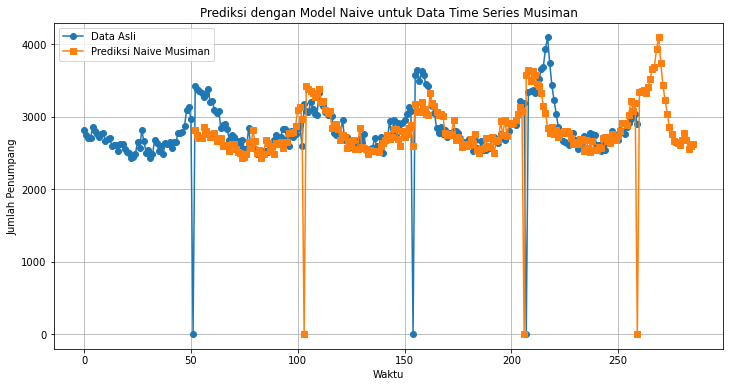

In [100]:
# Plot data asli dan prediksi Naive
plt.figure(figsize=(12, 6))
plt.plot(train_df, label='Data Asli', marker='o')
plt.plot(range(seasonal_period, len(train_df)+n_pred), naive_seasonal_predictions, label='Prediksi Naive Musiman', marker='s')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Penumpang')
plt.title('Prediksi dengan Model Naive untuk Data Time Series Musiman')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
# Function to calculate Mean Squared Error (MSE)
def calculate_mse(predictions, actual_data):
    mse = mean_squared_error(actual_data, predictions)
    return mse

# Function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(predictions, actual_data):
    mse = mean_squared_error(actual_data, predictions)
    rmse = np.sqrt(mse)
    return rmse


# Calculate MSE and RMSE
mse_naive_seasonal = calculate_mse(naive_seasonal_predictions[:len(test_df)], test_df)
rmse_naive_seasonal = calculate_rmse(naive_seasonal_predictions[:len(test_df)], test_df)

print(f"MSE Naive Musiman: {mse_naive_seasonal:.2f}")
print(f"RMSE Naive Musiman: {rmse_naive_seasonal:.2f}")

MSE Naive Musiman: 248050.04
RMSE Naive Musiman: 498.05


## Naive Seasonal Test - Long Term

In [107]:
n_pred = 52
seasonal_period = 52
naive_seasonal_predictions = naive_seasonal_forecast(train_df, seasonal_period, n_pred)

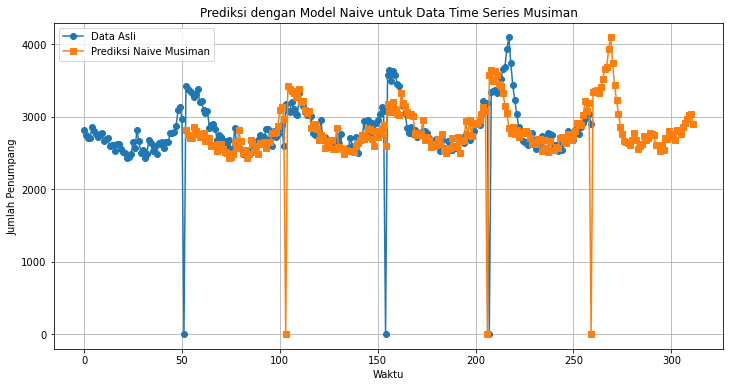

In [108]:
# Plot data asli dan prediksi Naive
plt.figure(figsize=(12, 6))
plt.plot(train_df, label='Data Asli', marker='o')
plt.plot(range(seasonal_period, len(train_df)+n_pred), naive_seasonal_predictions, label='Prediksi Naive Musiman', marker='s')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Penumpang')
plt.title('Prediksi dengan Model Naive untuk Data Time Series Musiman')
plt.legend()
plt.grid(True)
plt.show()

In [109]:
# Function to calculate Mean Squared Error (MSE)
def calculate_mse(predictions, actual_data):
    mse = mean_squared_error(actual_data, predictions)
    return mse

# Function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(predictions, actual_data):
    mse = mean_squared_error(actual_data, predictions)
    rmse = np.sqrt(mse)
    return rmse


# Calculate MSE and RMSE
mse_naive_seasonal = calculate_mse(naive_seasonal_predictions[:len(test_df)], test_df)
rmse_naive_seasonal = calculate_rmse(naive_seasonal_predictions[:len(test_df)], test_df)

print(f"MSE Naive Musiman: {mse_naive_seasonal:.2f}")
print(f"RMSE Naive Musiman: {rmse_naive_seasonal:.2f}")

MSE Naive Musiman: 248050.04
RMSE Naive Musiman: 498.05


# SARIMA

## Augmented Dickey–Fuller Test

Uji Augmented Dickey-Fuller digunakan untuk mengetahui stasioneritas dari suatu data deret waktu (time series data). Hampir sama dengan uji-t, tingkat signifikansi ditetapkan sebelum pengujian dan membuat kesimpulan atas hipotesis berdasarkan nilai p yang dihasilkan.

$H_0 : \text{Data tidak stasioner}$

$H_1 : \text{Data stasioner}$

Tolak $H_0$ jika:

$$p-value \leq \alpha \text{ (level signifikansi)}$$

$\alpha : (0.01, 0.05, 0.1, dll)$

In [110]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['All ages: both sexes'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -6.038625e+00
p-value                        1.362861e-07
#Lags Used                     3.000000e+00
Number of Observations Used    3.050000e+02
Critical Value (1%)           -3.451974e+00
Critical Value (5%)           -2.871063e+00
Critical Value (10%)          -2.571844e+00
dtype: float64


## Autocorrelation (ACF)

<Figure size 1152x432 with 0 Axes>

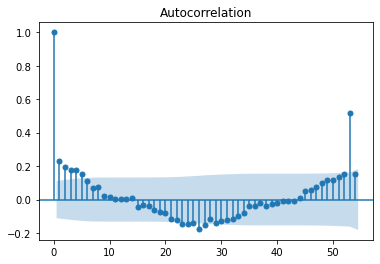

In [111]:
# Draw Plot
plt.figure(figsize=(16,6))
plot_acf(df['All ages: both sexes'], lags=54)
plt.show()


## Partial Autocorrelation (PACF)

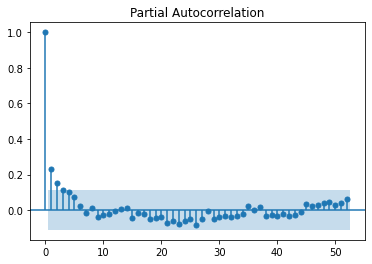

In [112]:
plot_pacf(df['All ages: both sexes'], lags=52)
plt.show()

## Data

In [113]:
sar_df = df.copy()

# Split train and test
train_df, test_df = train_test_split(sar_df, train_end, test_end)

## Built Model

In [114]:
# Find the best parameters for the seasonal ARIMA model
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

best_aic = float('inf')
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(sar_df['All ages: both sexes'], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

print('Best ARIMA Order:', best_order)
print('Best Seasonal Order:', best_seasonal_order)
print('Best AIC:', best_aic)

Best ARIMA Order: (1, 1, 1)
Best Seasonal Order: (1, 1, 1, 52)
Best AIC: 3029.505297603585


(0,1,1)(0,0,2,52) AIC: 3832.553807161994, BIC:3850.3379474704916,  MSE: 180992.47071717386
ARIMA(0, 1, 1)x(1, 0, 2, 52) -> AIC: 3823.010809660117, BIC:3844.351778030314,  MSE: 174226.08977179255
ARIMA(0, 1, 1)x(2, 0, 2, 52) -> AIC: 3815.0865282925442, BIC:3839.984324724441,  MSE: 170222.08256078235
ARIMA(0, 1, 2)x(2, 0, 2, 52) -> AIC: 3821.9588898815555, BIC:3850.413514375152,  MSE: 170169.62164634542

In [115]:
# Fit SARIMA
sarima_model = SARIMAX(train_df['All ages: both sexes'], 
                       order = (0, 1, 2), 
                       seasonal_order = (2, 0, 2, 52))
sarima_model_fit = sarima_model.fit(disp=0)
print(sarima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:               All ages: both sexes   No. Observations:                  260
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 52)   Log Likelihood               -1910.770
Date:                            Tue, 02 Jan 2024   AIC                           3835.539
Time:                                    07:13:08   BIC                           3860.437
Sample:                                01-12-2014   HQIC                          3845.550
                                     - 12-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8690      0.042    -20.844      0.000      -0.951      -0.787
ma.L2          0.0146      0.041   

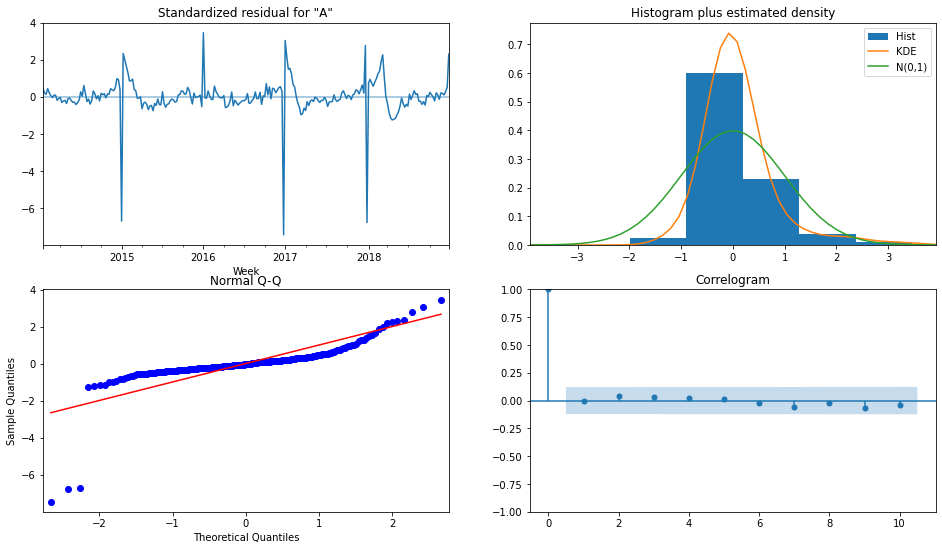

In [116]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(16, 9))
plt.show()

## SARIMA Test

In [117]:
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarima_predictions = sarima_model_fit.predict(start=pred_start_date, end=pred_end_date)
sarima_residuals = test_df['All ages: both sexes'] - sarima_predictions

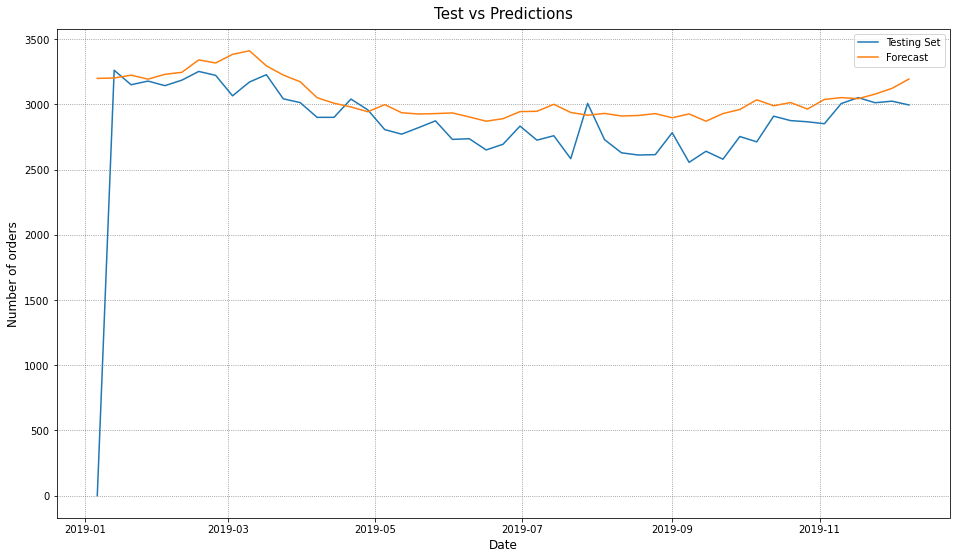

In [118]:
def plot_test_predictions(test_df: pd.DataFrame, predictions) -> None:
    
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    ax.plot(test_df, label='Testing Set')
    ax.plot(predictions, label='Forecast')

    # Labels
    ax.set_title("Test vs Predictions", fontsize=15, pad=10)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()

plot_test_predictions(test_df, sarima_predictions)

In [119]:
# Get evaluation data
sarima_aic = sarima_model_fit.aic
sarima_bic = sarima_model_fit.bic
sarima_mean_squared_error = sarima_model_fit.mse
sarima_sum_squared_error=sarima_model_fit.sse
sarima_root_mean_squared_error = np.sqrt(np.mean(sarima_residuals**2))

print(f'Akaike information criterion | AIC: {sarima_aic}')
print(f'Bayesian information criterion | BIC: {sarima_bic}')
print(f'Mean Squared Error | MSE: {sarima_mean_squared_error}')
print(f'Sum Squared Error | SSE: {sarima_sum_squared_error}')
print(f'Root Mean Squared Error | RMSE: {sarima_root_mean_squared_error}')

Akaike information criterion | AIC: 3835.539196164159
Bayesian information criterion | BIC: 3860.436992596056
Mean Squared Error | MSE: 179202.27952336485
Sum Squared Error | SSE: 46592592.67607486
Root Mean Squared Error | RMSE: 493.30013199534415


## Sarima Test - Short Term

In [122]:
# Forecast Window
n_sar_pred = 26
weeks_pred = n_sar_pred + 52

sarima_forecast = sarima_model_fit.forecast(weeks_pred)
sarima_forecast_series = pd.Series(sarima_forecast, index=sarima_forecast.index)

# Since negative orders are not possible we can trim them.
sarima_forecast_series[sarima_forecast_series < 0] = 0

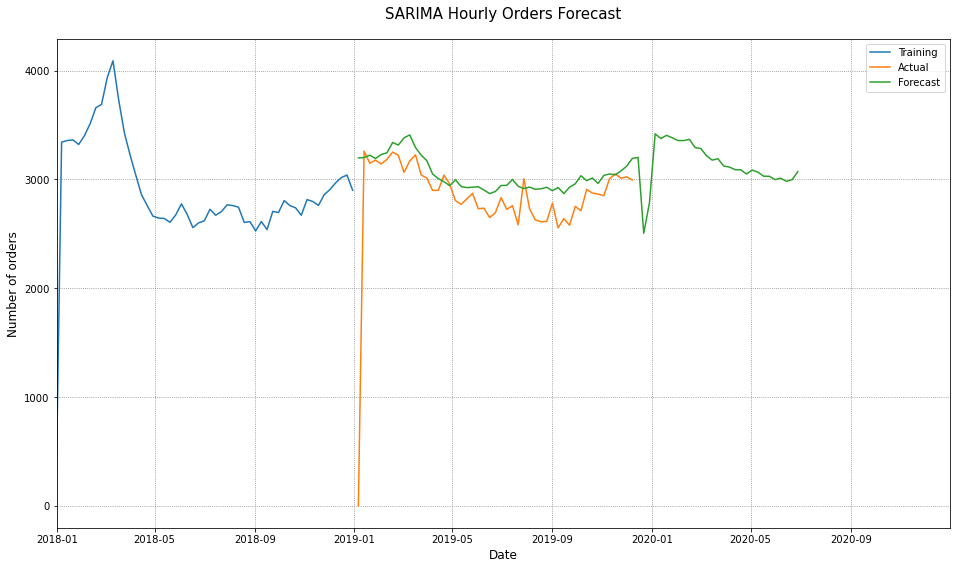

In [123]:
def plot_sarima_forecast(train_df: pd.DataFrame, test_df: pd.DataFrame, fc_series: pd.Series) -> None:

    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    # Plot Train, Test and Forecast.
    ax.plot(train_df['All ages: both sexes'], label='Training')
    ax.plot(test_df['All ages: both sexes'], label='Actual')
    ax.plot(fc_series, label='Forecast')

    # Labels
    ax.set_title("SARIMA Hourly Orders Forecast", fontsize=15, pad=20)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)

    xmin = datetime(2018, 1, 1)
    xmax = datetime(2020, 12, 31)
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    
    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()
    
plot_sarima_forecast(train_df, test_df, sarima_forecast_series)

## Sarima Test - Long Term

In [124]:
# Forecast Window
n_sar_pred = 52
weeks_pred = n_sar_pred + 52

sarima_forecast = sarima_model_fit.forecast(weeks_pred)
sarima_forecast_series = pd.Series(sarima_forecast, index=sarima_forecast.index)

# Since negative orders are not possible we can trim them.
sarima_forecast_series[sarima_forecast_series < 0] = 0

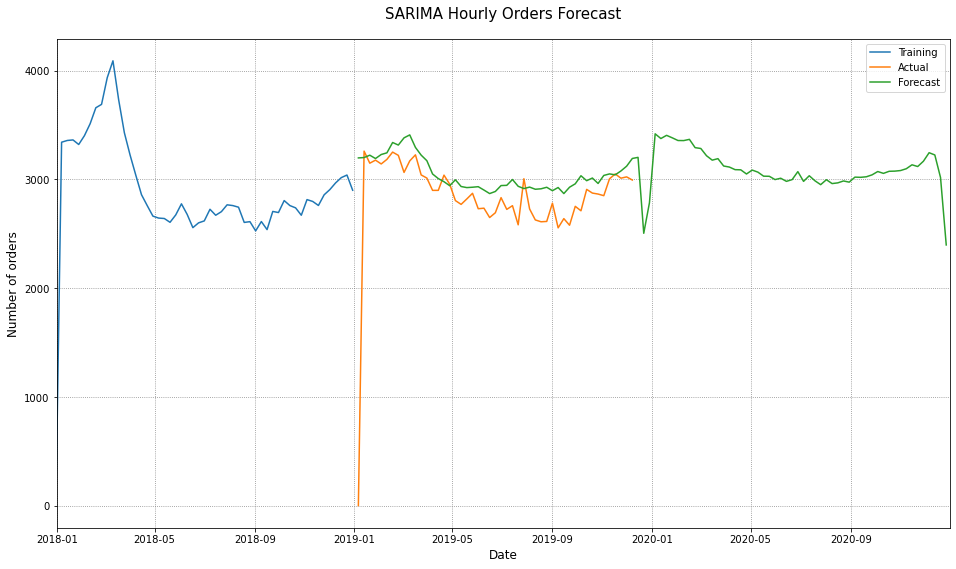

In [125]:
def plot_sarima_forecast(train_df: pd.DataFrame, test_df: pd.DataFrame, fc_series: pd.Series) -> None:

    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    # Plot Train, Test and Forecast.
    ax.plot(train_df['All ages: both sexes'], label='Training')
    ax.plot(test_df['All ages: both sexes'], label='Actual')
    ax.plot(fc_series, label='Forecast')

    # Labels
    ax.set_title("SARIMA Hourly Orders Forecast", fontsize=15, pad=20)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)

    xmin = datetime(2018, 1, 1)
    xmax = datetime(2020, 12, 31)
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    
    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()
    
plot_sarima_forecast(train_df, test_df, sarima_forecast_series)

# SARIMAX

## Data

In [126]:
sarx_df = df.copy()
sarx_df['Month_exog'] = sarx_df.index.month
sarx_df = sarx_df[['All ages: both sexes', 'Month_exog']]

## Build Dummy Data

In [128]:
Month_exog = sarx_df[(sarx_df != 0). all(1)]
Month_exog = Month_exog.groupby(Month_exog.index.month)['All ages: both sexes'].mean()
Month_exog

Week
1     3257.000000
2     3224.041667
3     3102.296296
4     2823.692308
5     2706.615385
6     2615.346154
7     2662.518519
8     2587.269231
9     2622.538462
10    2743.384615
11    2831.423077
12    2988.136364
Name: All ages: both sexes, dtype: float64

In [129]:
Month_exog = {key: (Month_exog[key]/ Month_exog[1]) for key in Month_exog.keys()}
Month_exog

{1: 1.0,
 2: 0.9898807696243986,
 3: 0.9525011655806865,
 4: 0.8669611015327933,
 5: 0.8310148555773365,
 6: 0.8029923714602867,
 7: 0.8174757502359591,
 8: 0.79437188540658,
 9: 0.8052006329562362,
 10: 0.8423041496421907,
 11: 0.869334687418814,
 12: 0.9174505261395037}

In [133]:
sarx_df.replace({'Month_exog' : Month_exog})

,All ages: both sexes,Month_exog
Week,,
2014-01-12,2819,1.000000
2014-01-19,2740,1.000000
2014-01-26,2710,1.000000
2014-02-02,2708,0.989881
2014-02-09,2855,0.989881
...,...,...
2019-11-10,3006,0.869335
2019-11-17,3051,0.869335
2019-11-24,3012,0.869335


## Split Train and Test Data

In [134]:
train_end = datetime(2019,1,1)
test_end = datetime(2020,1,1)

train_df, test_df = train_test_split(sarx_df, train_end, test_end)

## Built Model

In [135]:
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
s = 52

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]

def grid_search_sarimax(train_set: pd.DataFrame) -> None:
    
    # Grid Search
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            model = SARIMAX(train_set['All ages: both sexes'],
                            order=order,
                            seasonal_order=seasonal_order,
                            exog=train_set['Month_exog']
                            )
            try:
                results = model.fit(disp=0)
                print(f'ARIMA{order}x{seasonal_order} -> AIC: {results.aic}, BIC:{results.bic},  MSE: {results.mse}')
            except LinAlgError as e:
                print(f'ARIMA{order}x{seasonal_order} -> LinAlgError: {e}')
                # Additional debugging information or adjustments can be made here.

# Example usage:
# Assuming you have a training set called train_df
# grid_search_sarimax(train_df)


In [137]:
# Set Hyper-Parameters
p, d, q = 0, 1, 2
P, D, Q = 2, 0, 2
s = 52
exog = train_df['Month_exog']

# Fit SARIMAX
sarimax_model = SARIMAX(train_df['All ages: both sexes'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                exog=exog)

sarimax_model_fit = sarimax_model.fit(disp=0)

# Summary
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:               All ages: both sexes   No. Observations:                  260
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 52)   Log Likelihood               -1902.979
Date:                            Tue, 02 Jan 2024   AIC                           3821.959
Time:                                    07:33:39   BIC                           3850.414
Sample:                                01-12-2014   HQIC                          3833.399
                                     - 12-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Month_exog   -41.7040      7.432     -5.611      0.000     -56.271     -27.137
ma.L1         -0.8675      0.052   

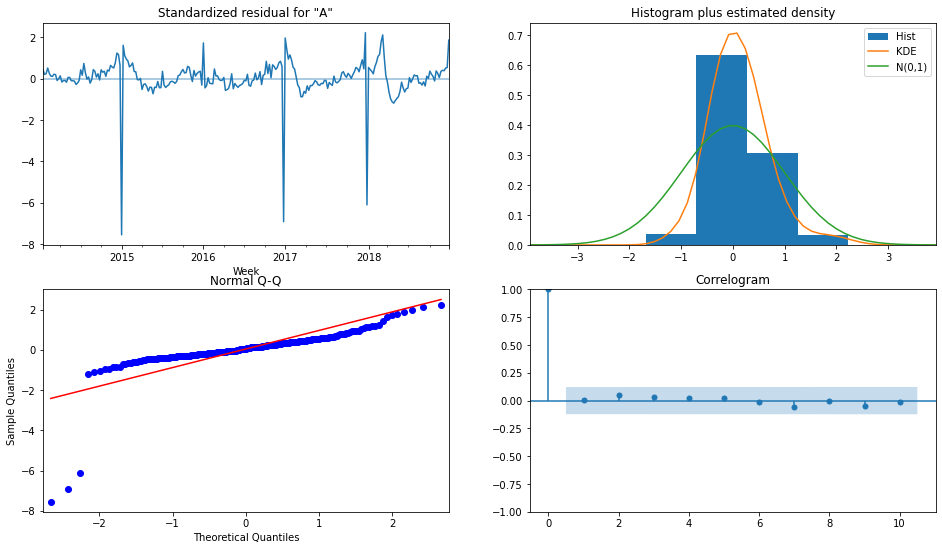

In [138]:
#Plot diagnostics
sarimax_model_fit.plot_diagnostics(figsize=(16, 9))
plt.show()

## SARIMAX Test

In [139]:
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

exog = test_df['Month_exog']
predictions = sarimax_model_fit.predict(start=pred_start_date, end=pred_end_date, exog=exog)
residuals = test_df['All ages: both sexes'] - predictions

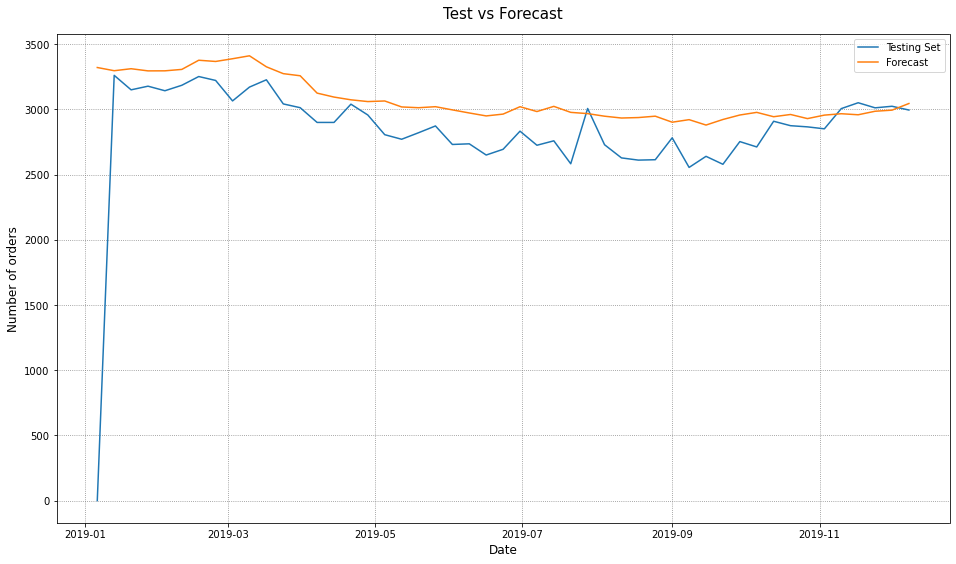

In [140]:
def plot_sarimax_test(test_set: pd.DataFrame, predictions: pd.Series) -> None:

    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    ax.plot(test_set['All ages: both sexes'], label='Testing Set')
    ax.plot(predictions, label='Forecast')

    # Labels
    ax.set_title("Test vs Forecast", fontsize=15, pad=15)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()

    
plot_sarimax_test(test_df, predictions)

In [141]:
# Get evaluation data
sarimax_aic = sarimax_model_fit.aic
sarimax_bic = sarimax_model_fit.bic
sarimax_mean_squared_error = sarimax_model_fit.mse
sarimax_sum_squared_error=sarimax_model_fit.sse
sarimax_root_mean_squared_error = np.sqrt(np.mean(residuals**2))

print(f'Akaike information criterion | AIC: {sarimax_aic}')
print(f'Bayesian information criterion | BIC: {sarimax_bic}')
print(f'Mean Squared Error | MSE: {sarimax_mean_squared_error}')
print(f'Sum Squared Error | SSE: {sarimax_sum_squared_error}')
print(f'Root Mean Squared Error | RMSE: {sarimax_root_mean_squared_error}')

Akaike information criterion | AIC: 3821.9588898815555
Bayesian information criterion | BIC: 3850.413514375152
Mean Squared Error | MSE: 170169.62164634542
Sum Squared Error | SSE: 44244101.628049806
Root Mean Squared Error | RMSE: 518.4485996591957


## Sarimax Test - Short Term

In [180]:
# Forecast Window
n_sarx_pred = 26
sarx_weeks_pred = n_sar_pred + 52
exog = pd.date_range(start='2018-01-01', end='2019-12-31', freq='W')

fc = sarimax_model_fit.forecast(sarx_weeks_pred, exog=exog.weekday)
fc_series = pd.Series(fc, index=fc.index)

# Since negative orders are not possible we can trim them.
fc_series[fc_series < 0] = 0

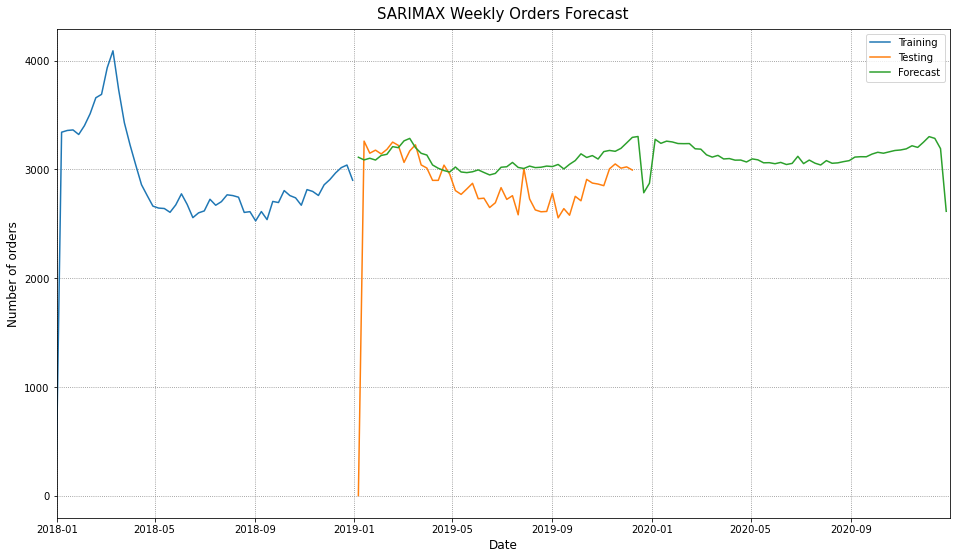

In [181]:
def plot_sarimax_forecast(train_df: pd.DataFrame, test_df: pd.DataFrame, fc_series: pd.Series) -> None:

    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    # Plot Train, Test and Forecast.
    ax.plot(train_df['All ages: both sexes'], label='Training')
    ax.plot(test_df['All ages: both sexes'], label='Testing')
    ax.plot(fc_series, label='Forecast')

    # Labels
    ax.set_title("SARIMAX Weekly Orders Forecast", fontsize=15, pad=10)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Axis Limits
    xmin = datetime(2018, 1, 1)
    xmax = datetime(2020, 12, 31)
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])

    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()


plot_sarimax_forecast(train_df, test_df, fc_series)

## Sarimax Test - Long Term

In [189]:
# Forecast Window
n_sarx_pred = 52
sarx_weeks_pred = n_sar_pred + 104
exog = pd.date_range(start='2018-01-01', end='2020-12-31', freq='W')

fc = sarimax_model_fit.forecast(sarx_weeks_pred, exog=exog.weekday)
fc_series = pd.Series(fc, index=fc.index)

# Since negative orders are not possible we can trim them.
fc_series[fc_series < 0] = 0

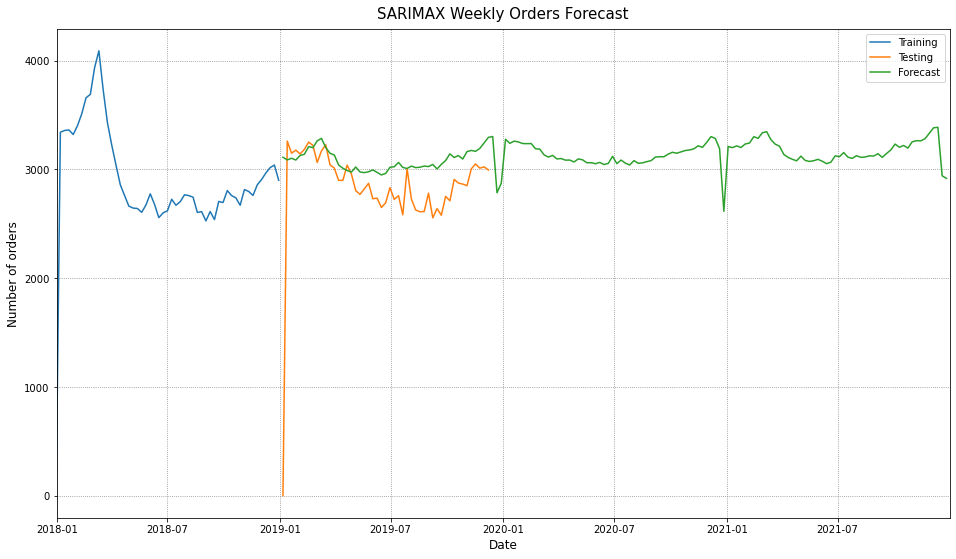

In [187]:
def plot_sarimax_forecast(train_df: pd.DataFrame, test_df: pd.DataFrame, fc_series: pd.Series) -> None:

    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    # Plot Train, Test and Forecast.
    ax.plot(train_df['All ages: both sexes'], label='Training')
    ax.plot(test_df['All ages: both sexes'], label='Testing')
    ax.plot(fc_series, label='Forecast')

    # Labels
    ax.set_title("SARIMAX Weekly Orders Forecast", fontsize=15, pad=10)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Axis Limits
    xmin = datetime(2018, 1, 1)
    xmax = datetime(2021, 12, 31)
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])

    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()


plot_sarimax_forecast(train_df, test_df, fc_series)